In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("darkgrid")

from math import sqrt, pi

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

## Functions 

In [2]:
def prepareData(sklearnDataSet):
    
    X, y = sklearnDataSet(return_X_y=True)
    data  = np.hstack([X,y.reshape(-1,1)])
    cols_name_lst = [f"feature_{i+1}" for i in range(X.shape[1])] + ["target"]
    return pd.DataFrame(data, columns = cols_name_lst)

def gaussian(x, mu, sig):
    aux = 2*(sig**2)
    return np.exp(-(x - mu)**2 /aux)/sqrt(aux)

def gaussian_plot(s):
    
    fig = plt.figure(figsize=(20,4))
    
    means_lst=[]
    std_lst=[]
    
    for mean, std in zip(stats_df.iloc[:,1][0::2],stats_df.iloc[:,1][1::2]):
        means_lst.append(mean)
        std_lst.append(std)
        
    max_mean = max(means_lst)
    min_mean = min(means_lst)
    max_std  = max(std_lst)  
    
    x = np.linspace(min(means_lst)-3*max_std, max(means_lst)+3*max_std, 10000)

    for index, stats in enumerate(zip(means_lst, std_lst)):
        mean, std = stats
        y = [gaussian(i, mean, std) for i in x]
        plt.title(f"{s.name.upper()}")
        plt.plot(x, y, lw=2,label=index)
        plt.legend(fontsize=20,loc=3)
        
    plt.show()
    plt.close()
    
    return fig

## Loading Data 

In [3]:
cancer_df = prepareData(load_breast_cancer)
iris_df = prepareData(load_iris)

## Theory 

We want to calculate the probability of Y given the set of features:

$$
P(y|x_1, ..., x_n) = \frac{P(y)P(x_1, ..., x_n|y)}{P(x_1, ..., x_n)}\\
$$

Using the assumption of conditional independence between every pair of features:

$$
P(y|x_1, ..., x_n) = \frac{P(y)\prod_{i=1}^{n}P(x_i|y)}{P(x_1, ..., x_n)}\\
$$

Since $P(x_1, ..., x_n)$ is constant given the input, we can use the following classification rule:

$$
P(y|x_1, ..., x_n) \propto P(y)\prod_{i=1}^{n}P(x_i|y) \\
$$

## Gaussian Naive Bayes 

They originate from the assumption of independence among the input variables. Even though this assumption doesn't hold true in the vast majority of the cases, they often perform very good at many classification tasks, so they're quite popular.

Gaussian Naive Bayes stack another (mostly wrong) assumption: that the variables exhibit a Gaussian probability distribution.

In [5]:
def getStats(df):
    
    classes = list(map(int, df.target.unique()))
    return df.groupby("target")\
             .agg(["mean","std"]).T\
             .reset_index()\
             .rename(columns = {"level_0":"feature","level_1":"statistic"})\
             .pivot(index='feature', columns="statistic", values=classes)\
             .T
    
stats_df = getStats(iris_df)
stats_df

feature      feature_1  feature_2  feature_3  feature_4
  statistic                                            
0 mean        5.006000   3.428000   1.462000   0.246000
  std         0.352490   0.379064   0.173664   0.105386
1 mean        5.936000   2.770000   4.260000   1.326000
  std         0.516171   0.313798   0.469911   0.197753
2 mean        6.588000   2.974000   5.552000   2.026000
  std         0.635880   0.322497   0.551895   0.274650

**Gaussian equation**:
    
$$
P(X_i | y) = \frac{1}{\sqrt{2\pi\sigma_y^{2}}}\exp{\frac{-(x_i - \mu_y)^{2}}{2\sigma_y^{2}}}
$$

In [6]:
stats_df.index = map(lambda x: '_'.join(map(str,x)), stats_df.index)
stats_df = stats_df[sorted(stats_df.columns, key=lambda x: int(x.split('_')[1]))]

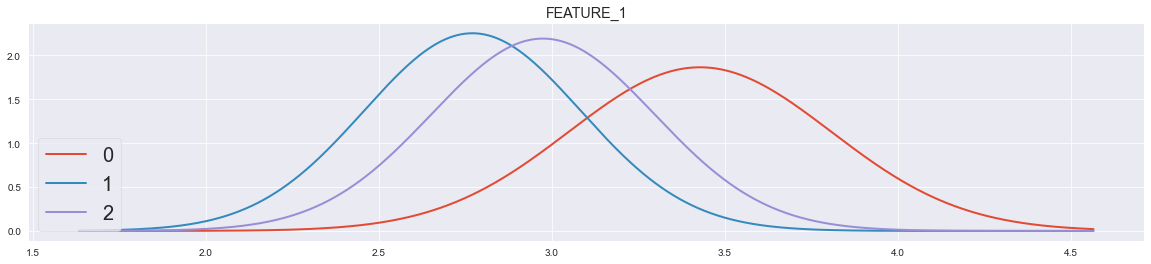

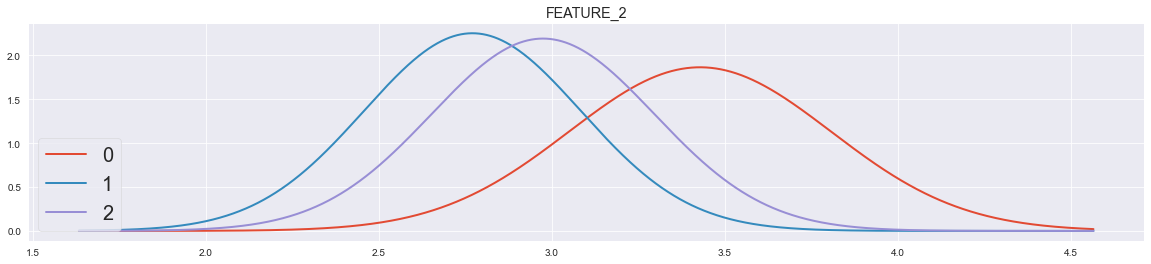

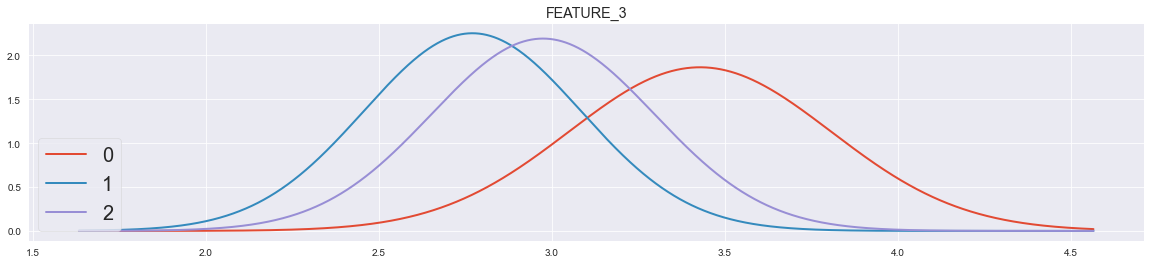

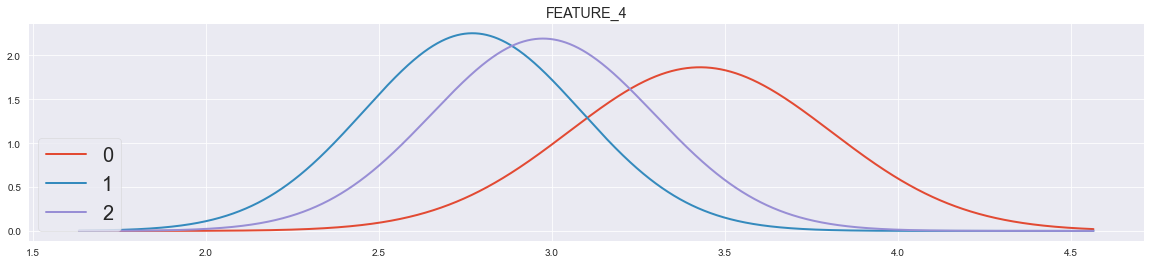

In [8]:
_ = stats_df.iloc[:,:4].apply(gaussian_plot)